<a href="https://colab.research.google.com/github/ricardogr07/trabajo-final-series-tiempo/blob/main/src/proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Correr para instalar librerías necesarias
!pip install pandas matplotlib statsmodels scikit-learn numpy==1.23.5
!pip install pmdarima --no-cache-dir

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Cargar dataset del precio del oro
try:
    oro = pd.read_csv("../dataset/oro.csv", parse_dates=["Date"], index_col="Date")
except FileNotFoundError:
    print("Archivo no encontrado. Descargando el dataset...")

    # Crear el directorio si no existe
    import os
    os.makedirs("../dataset", exist_ok=True)

    # URL del dataset mensual del precio del oro (USD/oz)
    url = "https://datahub.io/core/gold-prices/r/monthly.csv"

    # Leer y procesar
    oro = pd.read_csv(url, parse_dates=["Date"], index_col="Date")

    # Guardar en ../dataset/
    oro.to_csv("../dataset/oro.csv")
finally:
    print("Cargar información desde 2000.")
    oro = oro[oro.index >= "2000-01-01"]
    oro.rename(columns={"Price": "Gold_Price"}, inplace=True)
    print(oro.head())

Archivo no encontrado. Descargando el dataset...
Cargar información desde 2000.
            Gold_Price
Date                  
2000-01-01      284.32
2000-02-01      299.86
2000-03-01      286.39
2000-04-01      279.69
2000-05-01      275.19


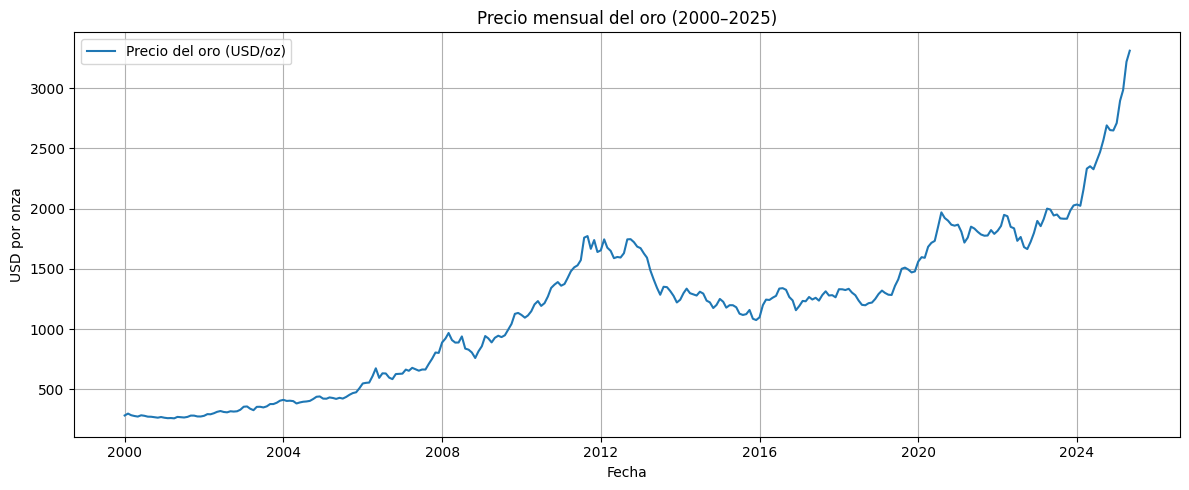

In [ ]:
# Graficar la serie de precios
plt.figure(figsize=(12, 5))
plt.plot(oro.index, oro["Gold_Price"], label="Precio del oro (USD/oz)")
plt.title("Precio mensual del oro (2000–2025)")
plt.xlabel("Fecha")
plt.ylabel("USD por onza")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Evaluación de la transformación logarítmica sobre el precio del oro

### Argumentos a favor de aplicar `log(Gold_Price)`

1. **Estabilización de la varianza**:  
   La gráfica del precio del oro en escala natural muestra una clara tendencia creciente, acompañada de un aumento en la amplitud de las fluctuaciones. Este patrón sugiere la presencia de heterocedasticidad, es decir, una varianza que crece con el nivel del precio. Al aplicar el logaritmo natural, se estabiliza la varianza relativa, lo cual es deseable para cumplir con los supuestos de modelos lineales como ARIMA o SARIMA.

2. **Interpretación económica**:  
   Modelar el logaritmo del precio permite interpretar las diferencias como tasas de crecimiento aproximadas. Esto es particularmente útil en series financieras y económicas donde se priorizan los cambios porcentuales más que los absolutos.

3. **Linealización de relaciones**:  
   En muchos casos, una serie con crecimiento exponencial o multiplicativo puede ser aproximada como aditiva después de una transformación logarítmica, facilitando el modelado con técnicas lineales.

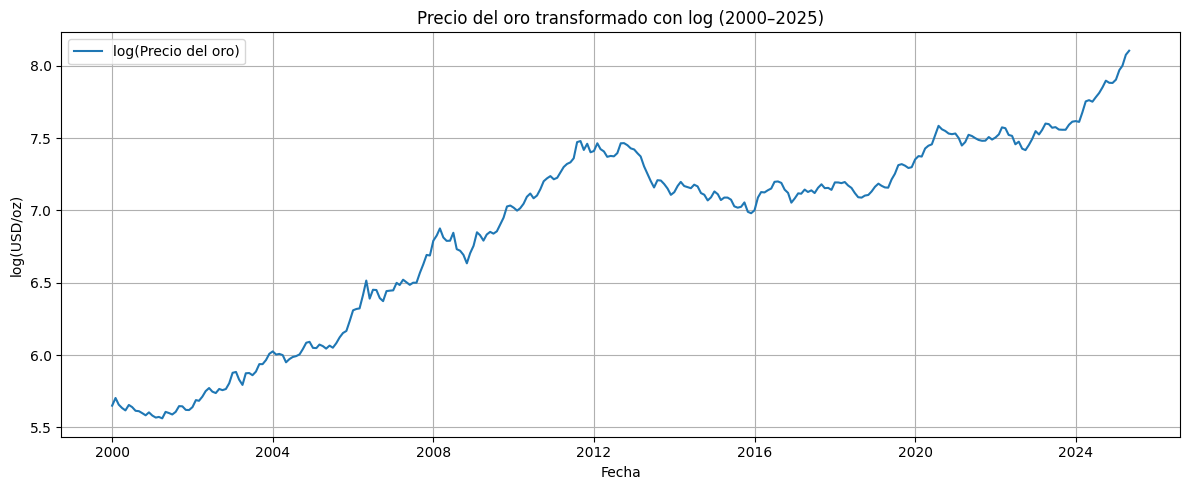

ADF Statistic: -0.3844943429455865
p-value: 0.9126556544790236
La serie NO es estacionaria.


In [ ]:
# Transformación logarítmica
oro["log_Gold_Price"] = np.log(oro["Gold_Price"])

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(oro.index, oro["log_Gold_Price"], label="log(Precio del oro)")
plt.title("Precio del oro transformado con log (2000–2025)")
plt.xlabel("Fecha")
plt.ylabel("log(USD/oz)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Prueba de estacionariedad ADF
resultado_adf = adfuller(oro["log_Gold_Price"].dropna())
print(f"ADF Statistic: {resultado_adf[0]}")
print(f"p-value: {resultado_adf[1]}")
if resultado_adf[1] < 0.05:
    print("La serie es estacionaria.")
else:
    print("La serie NO es estacionaria.")



Esto indica que la serie logarítmica no es estacionaria, ya que el p-value es muy superior al umbral comúnmente aceptado de 0.05.

### Conclusión

Aplicar la transformación logarítmica sobre el precio del oro es una decisión adecuada y justificada tanto desde una perspectiva estadística como interpretativa. Sin embargo, la serie resultante aún presenta no estacionariedad, por lo que se recomienda aplicar una diferenciación sobre `log(Gold_Price)` antes de proceder con el análisis de autocorrelaciones y el modelado.


## Análisis de autocorrelación y autocorrelación parcial sobre log-precios diferenciados

### Transformación adicional: primera diferencia de `log(Gold_Price)`

Dado que la serie `log(Gold_Price)` no es estacionaria según la prueba de Dickey-Fuller, se procede a aplicar una primera diferencia. Esto equivale a modelar los retornos logarítmicos, que en términos económicos representan las tasas de crecimiento relativas mensuales del precio del oro.

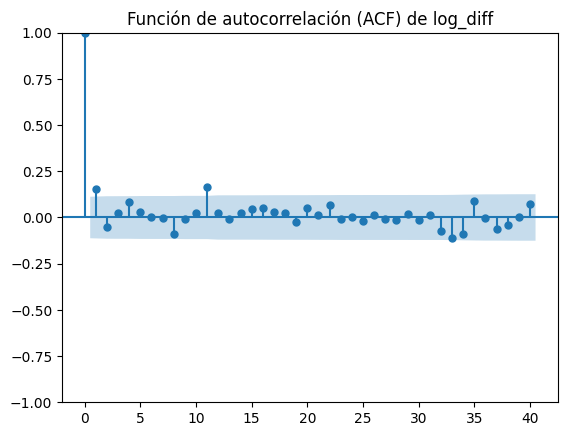

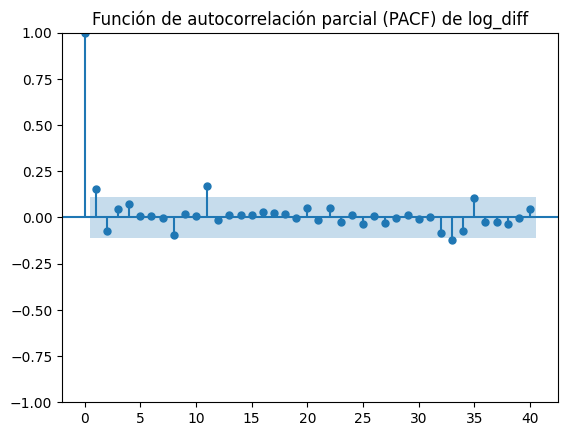

In [ ]:
# Calcular diferencia
oro["log_diff"] = oro["log_Gold_Price"].diff()
log_diff = oro["log_diff"].dropna()

# Graficar ACF
plot_acf(log_diff, lags=40)
plt.title("Función de autocorrelación (ACF) de log_diff")
plt.show()

# Graficar PACF
plot_pacf(log_diff, lags=40, method='ywm')
plt.title("Función de autocorrelación parcial (PACF) de log_diff")
plt.show()


## Interpretación de ACF y PACF sobre los log-retornos del precio del oro

Tras aplicar la primera diferencia a `log(Gold_Price)`, se analizaron las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) sobre la serie `log_diff`. Los gráficos resultantes se interpretan a continuación.

### ACF (Función de autocorrelación)

- Se observa un pico significativo en el lag 1, y posteriormente todas las autocorrelaciones caen dentro del intervalo de confianza.
- Este patrón es característico de una serie que puede ser bien modelada con una componente MA(1).

### PACF (Función de autocorrelación parcial)

- También presenta un solo pico significativo en el lag 1, con el resto de los valores no significativamente diferentes de cero.
- Este comportamiento sugiere la presencia de una estructura autoregresiva de primer orden, es decir, AR(1).


Ambas funciones ACF y PACF indican que la serie de log-retornos del precio del oro posee una estructura temporal simple, que puede ser bien capturada por un modelo ARMA(1,1).

Como siguiente paso, se recomienda construir y comparar los siguientes modelos candidatos:

- ARIMA(1,0,0): modelo autoregresivo puro
- ARIMA(0,0,1): modelo de media móvil
- ARIMA(1,0,1): combinación ARMA básica

Estos modelos serán evaluados con métricas de ajuste (AIC, BIC) y precisión predictiva (MAE, RMSE) mediante backtesting.


In [ ]:
log_diff = oro["log_diff"].dropna()

# Dividir en entrenamiento y prueba (últimos 6 meses para validación)
train = log_diff[:-6]
test = log_diff[-6:]

# Definir modelos ARIMA candidatos: (p, d, q)
modelos = {
    "AR(1)": (1, 0, 0),
    "MA(1)": (0, 0, 1),
    "ARMA(1,1)": (1, 0, 1),
    "ARMA(2,1)": (2, 0, 1),
    "ARMA(1,2)": (1, 0, 2),
    "ARMA(2,2)": (2, 0, 2)
}

# Evaluar cada modelo
resultados = []

for nombre, (p, d, q) in modelos.items():
    try:
        modelo = ARIMA(train, order=(p, d, q))
        resultado = modelo.fit()

        # Predicción sobre el set de prueba
        pred = resultado.forecast(steps=6)

        # Métricas
        mae = mean_absolute_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))

        resultados.append({
            "Modelo": nombre,
            "AIC": resultado.aic,
            "BIC": resultado.bic,
            "MAE": mae,
            "RMSE": rmse
        })
    except Exception as e:
        resultados.append({
            "Modelo": nombre,
            "AIC": None,
            "BIC": None,
            "MAE": None,
            "RMSE": None,
            "Error": str(e)
        })

# Mostrar resultados ordenados por RMSE
df_resultados = pd.DataFrame(resultados).sort_values(by="RMSE")
print(df_resultados)

      Modelo          AIC          BIC       MAE      RMSE
3  ARMA(2,1) -1136.032737 -1117.547269  0.031003  0.039113
4  ARMA(1,2) -1135.726051 -1117.240583  0.031131  0.039168
5  ARMA(2,2) -1133.797879 -1111.615318  0.031141  0.039204
2  ARMA(1,1) -1137.690196 -1122.901822  0.031285  0.039285
1      MA(1) -1138.808732 -1127.717451  0.031584  0.039298
0      AR(1) -1137.713627 -1126.622346  0.031925  0.039379


## Evaluación comparativa de modelos ARIMA para los log-retornos del precio del oro

Se probaron seis modelos ARIMA sin diferenciación adicional (d = 0), utilizando la serie `log_diff` de los log-retornos mensuales del precio del oro. La evaluación se realizó considerando métricas de ajuste (AIC, BIC) y precisión de predicción a 6 meses (MAE y RMSE). A continuación se analiza la tabla de resultados.

| Modelo     | AIC       | BIC       | MAE     | RMSE    |
|------------|-----------|-----------|---------|---------|
| ARMA(2,1)  | -1136.03  | -1117.55  | 0.0310  | 0.0391  |
| ARMA(1,2)  | -1135.73  | -1117.24  | 0.0311  | 0.0392  |
| ARMA(2,2)  | -1133.80  | -1111.62  | 0.0311  | 0.0392  |
| ARMA(1,1)  | -1137.69  | -1122.90  | 0.0313  | 0.0393  |
| MA(1)      | -1138.81  | -1127.72  | 0.0316  | 0.0393  |
| AR(1)      | -1137.71  | -1126.62  | 0.0319  | 0.0394  |

### Análisis

- **Precisión predictiva (MAE y RMSE)**:  
  El modelo ARMA(2,1) presenta el menor error absoluto medio (MAE = 0.0310) y el menor error cuadrático medio (RMSE = 0.0391), lo cual indica mejor desempeño en la predicción a corto plazo.

- **Criterios de información (AIC y BIC)**:  
  Aunque el modelo MA(1) tiene el mejor AIC (-1138.81), sus métricas de predicción son ligeramente peores. Asimismo, el modelo ARMA(1,1) presenta el segundo mejor AIC, pero no mejora en precisión predictiva respecto a ARMA(2,1).

- **Complejidad del modelo**:  
  El modelo ARMA(2,1) representa un equilibrio razonable entre complejidad y rendimiento. Modelos más complejos como ARMA(2,2) o ARMA(1,2) no aportan mejoras significativas en desempeño y sí aumentan el número de parámetros.

El modelo ARMA(2,1) es el más adecuado para continuar el análisis de los modelos que hemos comparado hasta el momento. Ofrece el mejor rendimiento en predicción a 6 meses y mantiene un nivel moderado de complejidad. Será utilizado para reconstruir el precio del oro en escala real y generar la proyección futura.

MAE: 254.04
RMSE: 326.34


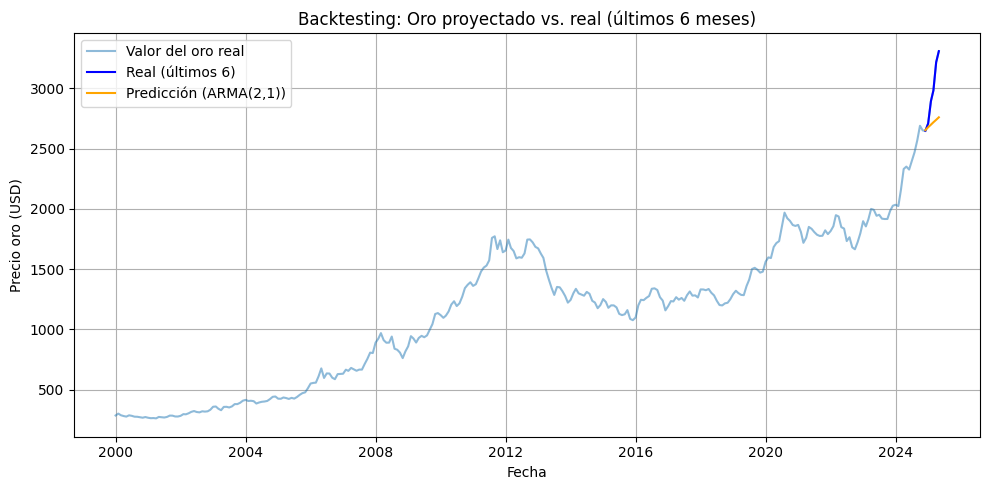

            Oro real  Predicción  Log-retorno predicho
Fecha                                                 
2024-12-01   2648.01     2654.07                  0.00
2025-01-01   2709.69     2678.17                  0.01
2025-02-01   2894.73     2699.22                  0.01
2025-03-01   2983.25     2719.26                  0.01
2025-04-01   3217.64     2739.68                  0.01
2025-05-01   3309.49     2760.32                  0.01


In [ ]:
# Filtrar datos
oro = oro.copy()
log_prices = oro["log_Gold_Price"].dropna()
log_returns = oro["log_diff"].dropna()

# Separar en entrenamiento y prueba (últimos 6 meses)
train = log_returns[:-6]
test = log_returns[-6:]
log_last_value = log_prices.iloc[-7]  # último valor ANTES del test

# Reentrenar ARMA(2,1)
modelo_val = ARIMA(train, order=(2, 0, 1))
resultado_val = modelo_val.fit()

# Predicción de log-retornos
forecast_log_returns = resultado_val.forecast(steps=6)

# Reconstrucción del precio del oro
forecast_log = log_last_value + forecast_log_returns.cumsum()
forecast_price = np.exp(forecast_log)

# Valores reales para comparar
real_price = np.exp(log_prices[-6:])

# Métricas de evaluación
mae = mean_absolute_error(real_price, forecast_price)
rmse = np.sqrt(mean_squared_error(real_price, forecast_price))
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))

# Visualización
plt.figure(figsize=(10,5))
plt.plot(np.exp(log_prices), label="Valor del oro real", alpha=0.5)
plt.plot(real_price.index, real_price.values, label="Real (últimos 6)", color='blue')
plt.plot(real_price.index, forecast_price.values, label="Predicción (ARMA(2,1))", color='orange')
plt.title("Backtesting: Oro proyectado vs. real (últimos 6 meses)")
plt.xlabel("Fecha")
plt.ylabel("Precio oro (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Tabla de predicción vs. realidad
tabla_backtest = pd.DataFrame({
    "Fecha": real_price.index,
    "Oro real": real_price.values,
    "Predicción": forecast_price.values,
    "Log-retorno predicho": forecast_log_returns.values
}).set_index("Fecha")

print(tabla_backtest.round(2))

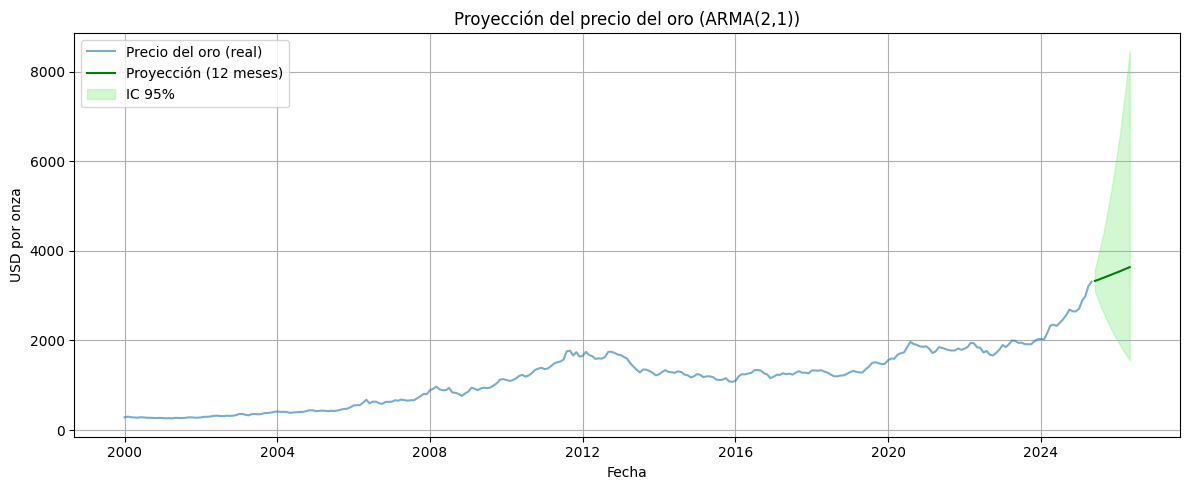

            Predicción  IC 95% Inferior  IC 95% Superior
Fecha                                                   
2025-06-01     3329.59          3106.38          3568.84
2025-07-01     3353.50          2916.16          3856.42
2025-08-01     3381.16          2740.22          4172.03
2025-09-01     3408.76          2574.66          4513.08
2025-10-01     3436.41          2418.99          4881.77
2025-11-01     3464.31          2272.74          5280.61
2025-12-01     3492.44          2135.34          5712.05
2026-01-01     3520.80          2006.24          6178.73
2026-02-01     3549.39          1884.95          6683.54
2026-03-01     3578.21          1770.99          7229.60
2026-04-01     3607.26          1663.92          7820.27
2026-05-01     3636.55          1563.33          8459.20


In [ ]:
# Reentrenar modelo sobre toda la serie de log-retornos
log_returns = oro["log_diff"].dropna()
log_prices = oro["log_Gold_Price"].dropna()
last_log = log_prices.iloc[-1]

modelo_full = ARIMA(log_returns, order=(2, 0, 1))
resultado_full = modelo_full.fit()

# Predecir 12 pasos adelante
n_steps = 12
forecast_result = resultado_full.get_forecast(steps=n_steps)
forecast_log_returns = forecast_result.predicted_mean
forecast_log_returns_ci = forecast_result.conf_int()

# Reconstruir log(Gold_Price)
forecast_log = last_log + forecast_log_returns.cumsum()
ci_lower_log = last_log + forecast_log_returns_ci.iloc[:, 0].cumsum()
ci_upper_log = last_log + forecast_log_returns_ci.iloc[:, 1].cumsum()

# Transformar a escala real
forecast_price = np.exp(forecast_log)
ci_lower = np.exp(ci_lower_log)
ci_upper = np.exp(ci_upper_log)

# Generar fechas futuras
last_date = oro.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_steps, freq='MS')

# Visualización
plt.figure(figsize=(12,5))
plt.plot(oro.index, oro["Gold_Price"], label="Precio del oro (real)", alpha=0.6)
plt.plot(future_dates, forecast_price, label="Proyección (12 meses)", color="green")
plt.fill_between(future_dates, ci_lower, ci_upper, color="lightgreen", alpha=0.4, label="IC 95%")
plt.title("Proyección del precio del oro (ARMA(2,1))")
plt.xlabel("Fecha")
plt.ylabel("USD por onza")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Tabla con predicciones
tabla_forecast = pd.DataFrame({
    "Fecha": future_dates,
    "Predicción": forecast_price.values,
    "IC 95% Inferior": ci_lower.values,
    "IC 95% Superior": ci_upper.values
}).set_index("Fecha")

print(tabla_forecast.round(2))


## Observaciones clave sobre la predicción del precio del oro con ARMA(2,1)

### 1. **Backtesting: comparación entre predicción y datos reales (últimos 6 meses)**

- **Comportamiento general**: El modelo ARMA(2,1) subestima el crecimiento observado en los últimos 6 meses de la serie. La curva de predicción (línea naranja) muestra una pendiente positiva, pero menos pronunciada que la observada en los datos reales (línea azul).
- **Desfase en nivel**: El modelo captura la dirección general del cambio, pero **queda corto en magnitud**, lo que sugiere que el modelo no alcanza a reflejar completamente la aceleración reciente en los precios del oro.
- **Conclusión**: Si bien el modelo muestra coherencia en la tendencia, su capacidad para anticipar movimientos abruptos o no lineales es limitada. Esto indica que el modelo puede requerir una reformulación o la inclusión de efectos exógenos (por ejemplo, indicadores macroeconómicos) para mejorar su capacidad predictiva.

---

### 2. **Proyección a 12 meses con intervalos de confianza**

- **Proyección puntual**: La línea verde representa la predicción puntual del precio del oro para los próximos 12 meses. El modelo proyecta un crecimiento moderado, sin anticipar un cambio de tendencia brusco.
- **Intervalos de confianza**: El área sombreada en verde claro representa el **intervalo de confianza al 95%**, que se ensancha de forma significativa a medida que avanza el horizonte temporal. Esto es característico en modelos ARMA, ya que la incertidumbre se acumula con el paso del tiempo.
- **Interpretación práctica**: Aunque la proyección central parece plausible, la amplitud de los intervalos sugiere **alta incertidumbre** en el pronóstico. El rango de valores proyectados va desde niveles ligeramente inferiores al valor actual hasta valores que duplican o triplican el precio.
- **Conclusión**: El modelo proporciona una visión razonable en el corto plazo (3–4 meses), pero su utilidad decrece más allá de ese horizonte. Para predicciones más robustas, podrían considerarse modelos más complejos o incorporar técnicas como SARIMA o modelos basados en redes neuronales recurrentes.

---

### Recomendación general

El modelo ARMA(2,1) presenta un buen equilibrio en capacidad explicativa. Sin embargo, tanto el backtesting como la proyección a 12 meses indican que su rendimiento es poco aceptable y bastante limitado. Su aplicación se justifica como una línea base estadística, pero no debería utilizarse de forma exclusiva para decisiones críticas sin validación adicional.


**MODELO ARIMA**

Además del enfoque explorado anteriormente, se implementó un modelo ARIMA directamente sobre la serie mensual de precios del oro. Para identificar la estructura temporal más adecuada, se compararon diez configuraciones ARIMA, evaluando el desempeño de cada modelo principalmente a través de los criterios de información de Akaike (AIC) y Bayesiano (BIC), y considerando adicionalmente los indicadores de error RMSE y MAE para asegurar un análisis más robusto.

Inicialmente, se probaron modelos básicos como Random Walk (ARIMA(0,1,0)), modelos autorregresivos y de medias móviles simples (ARIMA(1,1,0), ARIMA(0,1,1)), así como una configuración combinada (ARIMA(1,1,1)). Posteriormente, para afinar la selección y garantizar mayor robustez en el análisis, se amplió el set de modelos evaluados incluyendo configuraciones más complejas (por ejemplo, ARIMA(3,2,5), ARIMA(4,2,2), ARIMA(5,2,2)), utilizando una búsqueda sistemática con auto_arima para identificar el mejor ajuste posible.

In [ ]:
from pmdarima import ARIMA

ordenes = [
    (0,1,0),   # Random Walk
    (1,1,0),   # AR simple
    (0,1,1),   # MA simple
    (1,1,1),   # ARMA simple
    (2,1,1),   # ARMA intermedio
    (2,1,2),   # ARMA un poco más complejo
    (1,2,1),   # Un grado más de diferenciación
    (2,2,1),   # Mejor de tu tabla
    (2,2,2),   # AR y MA más largos con más diferencia
    (3,1,1),   # AR largo
    (1,1,2),   # MA largo
    (3,2,1),   # Más AR y diferencia
    (2,2,3),   # Más MA
    (3,2,2),   # AR y MA iguales, d alto
    (4,2,2),   # De los mejores en tu tabla
    (5,2,2),   # El más largo de tu tabla
    (3,2,5),   # El de menor RMSE/MAE en tu tabla
    (2,2,5),   # Para comparar solo MA largo
    (4,2,1),   # AR muy largo
    (3,1,3)    # Intermedio con diferencia menor
]

resultados = []

for orden in ordenes:
    y = oro['Gold_Price']
    modelo = ARIMA(order=orden).fit(y)
    aic = modelo.aic()
    bic = modelo.bic()
    pred = modelo.predict_in_sample()
    rmse = np.sqrt(mean_squared_error(y, pred))
    mae = mean_absolute_error(y, pred)
    resultados.append({
        'orden': orden,
        'AIC': aic,
        'BIC': bic,
        'RMSE': rmse,
        'MAE': mae
    })

df_resultados = pd.DataFrame(resultados)
print(df_resultados.sort_values(by='AIC'))


        orden          AIC          BIC       RMSE        MAE
7   (2, 2, 1)  3175.384312  3193.952976  48.063866  33.209713
6   (1, 2, 1)  3175.611858  3190.466789  48.212250  33.553006
11  (3, 2, 1)  3177.034052  3199.316449  48.041217  33.147894
8   (2, 2, 2)  3177.069712  3199.352109  48.043838  33.144866
16  (3, 2, 5)  3177.325381  3214.462709  47.484224  32.718684
13  (3, 2, 2)  3177.393980  3203.390109  47.922759  33.133663
14  (4, 2, 2)  3177.762811  3207.472674  47.812858  32.943997
12  (2, 2, 3)  3177.769326  3203.765455  47.946180  33.239164
17  (2, 2, 5)  3178.346054  3211.769650  47.680836  32.913937
18  (4, 2, 1)  3178.890941  3204.887071  48.031991  33.123220
15  (5, 2, 2)  3179.531300  3212.954895  47.795700  32.943940
19  (3, 1, 3)  3182.425905  3212.162126  46.739000  32.972325
10  (1, 1, 2)  3184.237710  3202.822848  47.314678  32.949040
9   (3, 1, 1)  3185.302217  3207.604383  47.242031  32.738051
1   (1, 1, 0)  3186.235059  3197.386142  47.801211  33.267678
5   (2, 

De acuerdo con estos resultados, el modelo ARIMA(3,2,5) destacó por presentar los menores valores de AIC y BIC dentro del grupo de modelos mejor rankeados, y mostró un desempeño consistente en los indicadores de error RMSE y MAE. Aunque algunas configuraciones alternativas presentaron valores cercanos de AIC o BIC, ARIMA(3,2,5) fue el que obtuvo los errores de predicción (RMSE y MAE) más bajos dentro de ese grupo, lo que evidencia un ajuste más eficiente a la estructura temporal de la serie de precios del oro. Esta selección fue el resultado de comparar veinte combinaciones diferentes de parámetros, lo que asegura un análisis robusto y una mayor confianza en el equilibrio entre calidad de ajuste y precisión de pronóstico.

# **Mejor Modelo**

De acuerdo con estos resultados, el modelo ARIMA(3,2,5) destacó por presentar los menores valores de AIC y BIC dentro del grupo de modelos mejor rankeados, y mostró un desempeño consistente en los indicadores de error RMSE y MAE. Aunque algunas configuraciones alternativas presentaron valores cercanos de AIC o BIC, ARIMA(3,2,5) fue el que obtuvo los errores de predicción (RMSE y MAE) más bajos dentro de ese grupo, lo que evidencia un ajuste más eficiente a la estructura temporal de la serie de precios del oro. Esta selección fue el resultado de comparar veinte combinaciones diferentes de parámetros, lo que asegura un análisis robusto y una mayor confianza en el equilibrio entre calidad de ajuste y precisión de pronóstico.

Dado que el modelo ARIMA(3,2,5) fue el que presentó el mejor desempeño general según los criterios de AIC, BIC, RMSE y MAE, se realizó el análisis detallado de sus resultados.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Serie
y = oro['Gold_Price']

# Ajustar el mejor modelo ARIMA
mejor_modelo = ARIMA(y, order=(3, 2, 5)).fit()

# Mostrar el summary completo
print(mejor_modelo.summary())

# Tabla resumen de los coeficientes principales
tabla_resumen = pd.DataFrame({
    'Coeficiente': mejor_modelo.params,
    'Std Error': mejor_modelo.bse,
    'p-value': mejor_modelo.pvalues
})

# Mostrar la tabla
print(tabla_resumen)

                               SARIMAX Results                                
Dep. Variable:             Gold_Price   No. Observations:                  305
Model:                 ARIMA(3, 2, 5)   Log Likelihood               -1579.089
Date:                Sun, 13 Jul 2025   AIC                           3176.177
Time:                        20:36:13   BIC                           3209.601
Sample:                    01-01-2000   HQIC                          3189.549
                         - 05-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2157      0.159     -1.359      0.174      -0.527       0.096
ar.L2         -0.4105      0.120     -3.432      0.001      -0.645      -0.176
ar.L3         -0.7692      0.166     -4.623      0.0

# Pronóstico

Una vez validado el ajuste del modelo, se generó el pronóstico para los próximos 12 meses, presentando los resultados tanto en formato tabular como gráfico para facilitar su interpretación.

Pronóstico e intervalo de confianza para los próximos 12 meses:


,Fecha,Pronóstico,Límite Inferior,Límite Superior
0,2025-06-01,3362.502934,3274.769099,3450.236769
1,2025-07-01,3456.975161,3315.112505,3598.837817
2,2025-08-01,3530.294383,3347.492851,3713.095916
3,2025-09-01,3608.228967,3388.231751,3828.226183
4,2025-10-01,3661.678680,3408.889382,3914.467978
5,2025-11-01,3734.786368,3446.576283,4022.996453
6,2025-12-01,3810.154926,3485.565522,4134.744330
7,2026-01-01,3895.799703,3533.985964,4257.613442
8,2026-02-01,3963.178644,3566.497766,4359.859523
9,2026-03-01,4028.540098,3597.143307,4459.936888


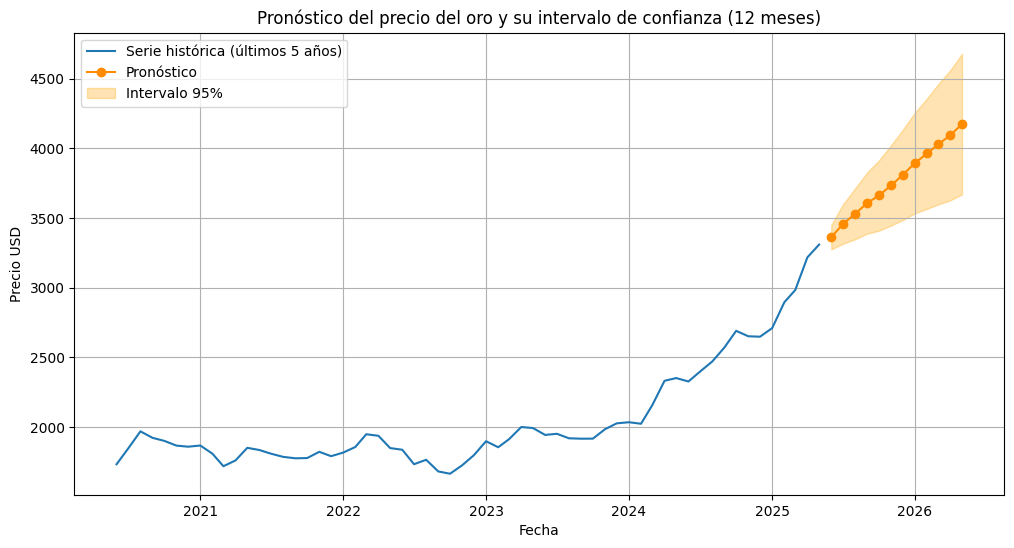

In [ ]:
# Determinar el último mes de la serie
ultimo_mes = oro.index[-1]

# Generar fechas para los siguientes 12 meses
fechas_futuras = pd.date_range(start=ultimo_mes + pd.offsets.MonthBegin(1), periods=12, freq='MS')

# Hacer pronóstico (forecast)
prediccion = mejor_modelo.get_forecast(steps=12)
media_pred = prediccion.predicted_mean
intervalo_conf = prediccion.conf_int()

# Crear DataFrame resumen
resultados_forecast = pd.DataFrame({
    'Fecha': fechas_futuras,
    'Pronóstico': media_pred.values,
    'Límite Inferior': intervalo_conf.iloc[:,0].values,
    'Límite Superior': intervalo_conf.iloc[:,1].values
})

# Mostrar tabla
print("Pronóstico e intervalo de confianza para los próximos 12 meses:")
display(resultados_forecast)

# Graficar
plt.figure(figsize=(12,6))
plt.plot(oro.index[-60:], oro['Gold_Price'][-60:], label='Serie histórica (últimos 5 años)')
plt.plot(resultados_forecast['Fecha'], resultados_forecast['Pronóstico'], marker='o', color='darkorange', label='Pronóstico')
plt.fill_between(resultados_forecast['Fecha'],
                 resultados_forecast['Límite Inferior'],
                 resultados_forecast['Límite Superior'],
                 color='orange', alpha=0.3, label='Intervalo 95%')
plt.title('Pronóstico del precio del oro y su intervalo de confianza (12 meses)')
plt.xlabel('Fecha')
plt.ylabel('Precio USD')
plt.legend()
plt.grid(True)
plt.show()

Los valores proyectados mantienen la tendencia creciente registrada en los últimos años. Los intervalos de confianza al 95% permiten dimensionar el rango dentro del cual podría fluctuar el precio, con una mayor amplitud hacia el final del periodo.

Además, la gráfica ilustra de manera clara cómo el pronóstico sigue la línea alcista reciente del oro, mostrando además la magnitud de la incertidumbre asociada a cada estimación. Este comportamiento es relevante porque, aunque el modelo incorpora la información histórica para proyectar, siempre existe un margen de variabilidad, especialmente en mercados sujetos a shocks externos.